# Problem Statement

In this competition, goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

In [117]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv


In [118]:
# Importng Required Libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Prepration

### Load Data

In [119]:
train = pd.read_csv(r'/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv(r'/kaggle/input/digit-recognizer/test.csv')

In [120]:
y_train = train['label']
X_train=train.drop('label',axis=1)

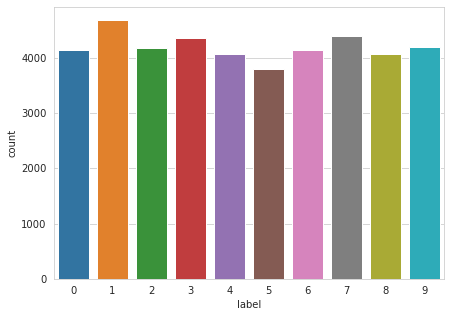

In [121]:
sns.set_style('whitegrid')
plt.figure(figsize=(7,5))
sns.countplot(y_train)

### Check for Missing Values

In [122]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [123]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### Normalization

In [124]:
X_train /= 255.0
test /= 255.0

### Reshape

In [125]:
X_train=X_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

### Label Encoding

In [126]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)

### Split Training and Validation Set

In [127]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

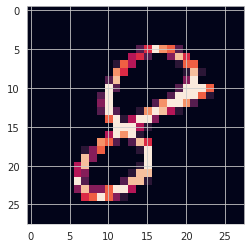

In [128]:
plt.imshow(X_train[0][:,:,0])

In [129]:
y_train.shape

(37800, 10)

## CNN

### Defining the model

In [130]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(5,5),activation='relu',padding='same',input_shape=(28,28,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(5,5),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2),strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2),strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10,activation='softmax')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 64)       

### Initializing Optimizer

In [131]:
optimizer=tf.keras.optimizers.RMSprop(lr=0.001)

In [132]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

### Data Augmentation

In [133]:
from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(rotation_range=40,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True,
                          fill_mode='nearest')
datagen.fit(X_train)

In [134]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler( lambda epoch : 1e-8 * 10 ** (epoch/15))

In [135]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=120),
                              epochs = 75, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // 120
                              , callbacks=[lr_schedule])

Train for 315 steps, validate on 4200 samples
Epoch 1/75
315/315 - 13s - loss: 3.2832 - acc: 0.1055 - val_loss: 2.7112 - val_acc: 0.0971
Epoch 2/75
315/315 - 12s - loss: 3.2670 - acc: 0.1060 - val_loss: 2.6197 - val_acc: 0.0912
Epoch 3/75
315/315 - 12s - loss: 3.2699 - acc: 0.1026 - val_loss: 2.6222 - val_acc: 0.0843
Epoch 4/75
315/315 - 12s - loss: 3.2702 - acc: 0.1044 - val_loss: 2.6187 - val_acc: 0.0821
Epoch 5/75
315/315 - 12s - loss: 3.2877 - acc: 0.1014 - val_loss: 2.6182 - val_acc: 0.0810
Epoch 6/75
315/315 - 12s - loss: 3.2640 - acc: 0.1043 - val_loss: 2.6154 - val_acc: 0.0814
Epoch 7/75
315/315 - 12s - loss: 3.2738 - acc: 0.1048 - val_loss: 2.6129 - val_acc: 0.0821
Epoch 8/75
315/315 - 13s - loss: 3.2772 - acc: 0.1033 - val_loss: 2.6115 - val_acc: 0.0821
Epoch 9/75
315/315 - 12s - loss: 3.2806 - acc: 0.1042 - val_loss: 2.6086 - val_acc: 0.0833
Epoch 10/75
315/315 - 12s - loss: 3.2651 - acc: 0.1071 - val_loss: 2.6049 - val_acc: 0.0829
Epoch 11/75
315/315 - 12s - loss: 3.2663 - 

KeyboardInterrupt: 

### Evaluating the Model

In [ ]:
plt.figure(figsize=(10,6))
ax1 = plt.subplot(1,2,1)
ax1.plot(history.history['loss'], color='b', label='Training Loss') 
ax1.plot(history.history['val_loss'], color='r', label = 'Validation Loss',axes=ax1)
legend = ax1.legend(loc='best', shadow=True)
ax2 = plt.subplot(1,2,2)
ax2.plot(history.history['acc'], color='b', label='Training Accuracy') 
ax2.plot(history.history['val_acc'], color='r', label = 'Validation Accuracy')
legend = ax2.legend(loc='best', shadow=True)

### Confusion Matrix

In [ ]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_true,y_pred_classes,title='Confusion Matrix for Train Data')

### Predicting results on test data

In [ ]:
results = model.predict(test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name='Label')

In [ ]:
submission = pd.concat([pd.Series(range(1,28001), name='ImageId'), results], axis=1)
submission.to_csv(r'Digit_Recognizer', index=False)